<a href="https://colab.research.google.com/github/zhueric2004/quant-assessment/blob/main/ConsumerComplaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Complaints Data Analysis

Import needed libraries


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from google.colab import drive
from statsmodels.formula.api import ols
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reads files from Google Drive, your file path may be different

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Quant/consumer_complaints.csv")
populations = pd.read_csv("/content/drive/MyDrive/Quant/Populations.csv")
stateMap = gpd.read_file("/content/drive/MyDrive/Quant/tl_2021_us_state/tl_2021_us_state.shp")  
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


Any irrelevant column that will not affect our data analysis is deleted from the datasets

In [ ]:
data.drop(['date_sent_to_company','date_received','consumer_consent_provided','complaint_id','company'], axis = 1, inplace = True)
data.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,state,zipcode,tags,submitted_via,company_response_to_consumer,timely_response,consumer_disputed?
0,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,CA,95993,NaN,Referral,Closed with explanation,Yes,Yes
1,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,CA,91104,NaN,Referral,Closed with explanation,Yes,Yes
2,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,NY,11764,NaN,Postal mail,Closed with explanation,Yes,No
3,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,MD,21402,NaN,Email,Closed with explanation,Yes,Yes
4,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,GA,30106,NaN,Web,Closed with explanation,Yes,Yes


Removes all irrelevant columns from the GeoDataFrame

In [ ]:
stateMap = stateMap.drop([34,35,36,41])

In [ ]:
stateMap.drop(['REGION','DIVISION','STATEFP','STATENS','GEOID', 'LSAD', 'MTFCC', 'FUNCSTAT','ALAND', 'AWATER'], axis = 1, inplace = True)
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428..."
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067..."
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295..."
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373..."


Finds the frequency of each entry in a column and converts it to a dataframe

In [ ]:
def frequencyToDataframe(df, column):
  return df[column].value_counts().to_frame()

Takes the dataframe above and merges it with the shapefile

In [ ]:
def frequencyByState(df, newName, stateMap):
  df.index.names = ['STUSPS']
  df.rename({'state': newName}, axis='columns', inplace = True)
  stateMap = stateMap.merge(df, on='STUSPS')
  return stateMap

# Analyzing Complaints and Disputers per State
Counts the number of total entries per state and merges with shapefile

In [ ]:
stateFreq = frequencyToDataframe(data, 'state')
stateMap = frequencyByState(stateFreq, 'total', stateMap)

Merges the population dataset with the shapefile to do per capita analysis

In [ ]:
stateMap = stateMap.merge(populations, on = 'NAME')

Population is entered as string, is converted into float for mathematical purposes

In [ ]:
stateMap['Population'] = stateMap['Population'].str.replace(',', '').astype(float)
stateMap["proportion"] = stateMap["total"]/stateMap["Population"] * 100
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry,total,Population,proportion
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428...",1457,1782959.0,0.081718
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",53673,21781128.0,0.246420
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067...",19624,12671469.0,0.154868
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295...",6424,5707390.0,0.112556
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373...",17703,6165129.0,0.287147


Creates a choropleth using values in a given column in the shapefile

In [ ]:
def choropleth(column, label, title): 
  fig, ax = plt.subplots(figsize=(25, 10))
  stateMap.plot(column=column, 
              legend = True, ax = ax,
              edgecolor="white",
              legend_kwds={'label': title,
                        'orientation': "vertical"})
  ax.set_xlim(-130, -63)
  ax.set_ylim(23, 50)
  ax.set_title(label)

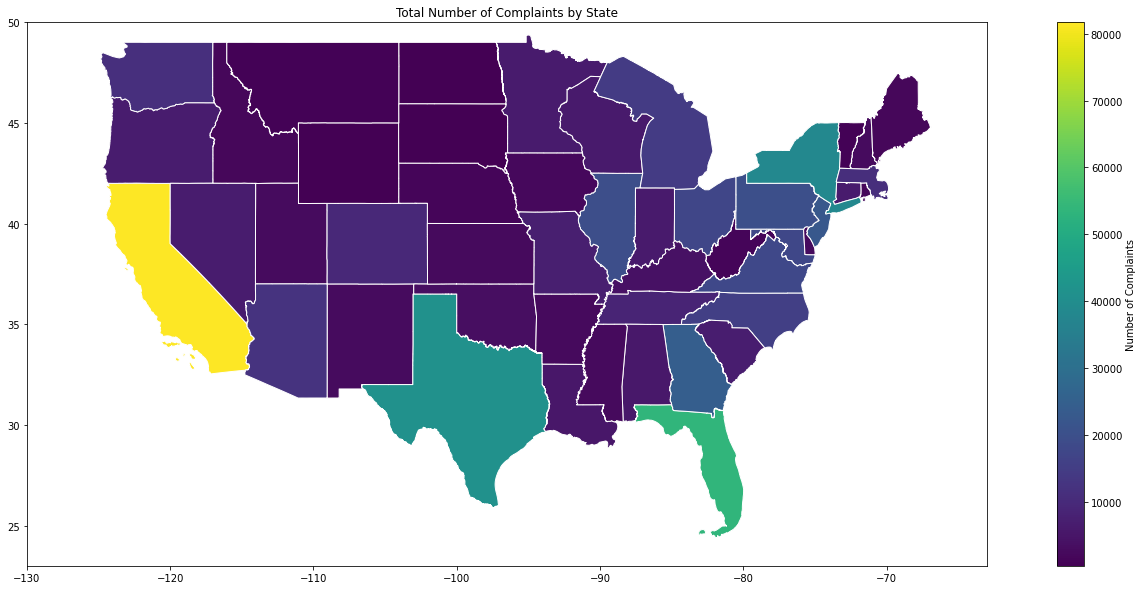

In [ ]:
choropleth('total', 'Total Number of Complaints by State', 'Number of Complaints')

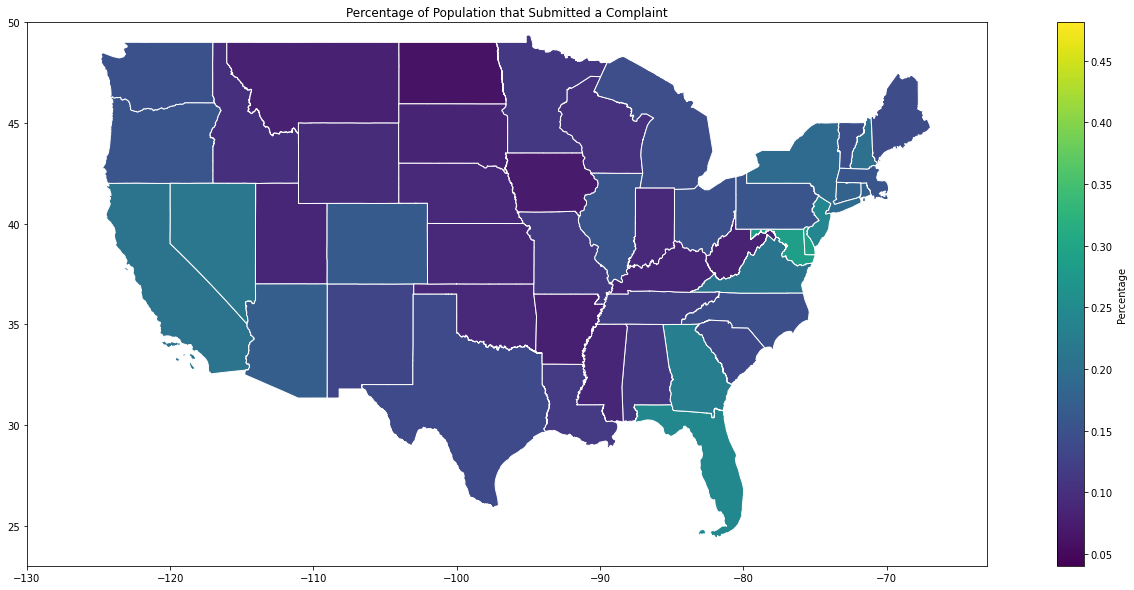

In [ ]:
choropleth('proportion', 'Percentage of Population that Submitted a Complaint', 'Percentage')

Sums the total yes/no responses per state in the consumer_disputed? and timely_response columns

In [ ]:
def calculateYesNo(column, stateMap, name):
  yesVar = data.loc[(data[column]  == 'Yes')]
  yesVar = frequencyToDataframe(yesVar, 'state')
  noVar = data.loc[(data[column]  == 'No')]
  noVar = frequencyToDataframe(noVar, 'state')
  stateMap = frequencyByState(yesVar, name, stateMap)
  stateMap = frequencyByState(noVar, 'non' + name, stateMap)
  return stateMap

In [ ]:
stateMap = calculateYesNo('consumer_disputed?', stateMap, 'disputes')

In [ ]:
stateMap["disputesPerCapita"] = stateMap["disputes"] / stateMap["Population"] * 100
stateMap["percentDisputed"] = stateMap["disputes"] / (stateMap["nondisputes"] + stateMap["disputes"]) * 100
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry,total,Population,proportion,disputes,nondisputes,disputesPerCapita,percentDisputed
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428...",1457,1782959.0,0.081718,266,1191,0.014919,18.256692
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",53673,21781128.0,0.246420,10443,43230,0.047945,19.456710
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067...",19624,12671469.0,0.154868,4156,15468,0.032798,21.178149
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295...",6424,5707390.0,0.112556,1319,5105,0.023110,20.532379
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373...",17703,6165129.0,0.287147,3890,13813,0.063097,21.973677


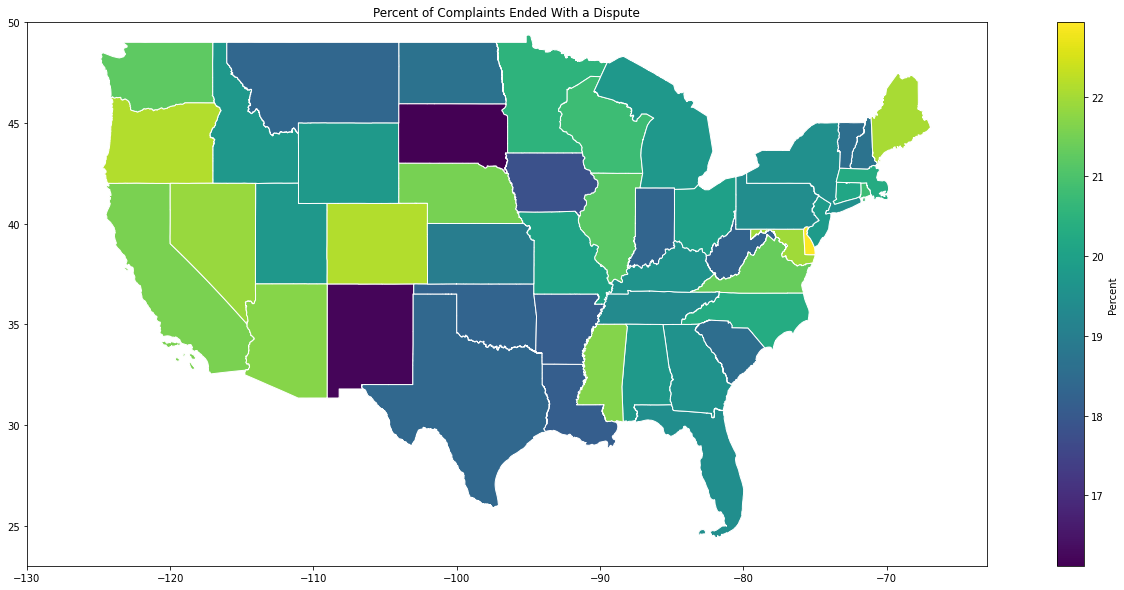

In [ ]:
choropleth('percentDisputed', 'Percent of Complaints Ended With a Dispute', 'Percent')

In [ ]:
stateMap = calculateYesNo('timely_response', stateMap, 'timely')

In [ ]:
stateMap["percentTimely"] = (stateMap["timely"] / (stateMap["timely"] + stateMap["nontimely"])) * 100
stateMap.head()

,STUSPS,NAME,INTPTLAT,INTPTLON,geometry,total,Population,proportion,disputes,nondisputes,disputesPerCapita,percentDisputed,timely,nontimely,percentTimely
0,WV,West Virginia,+38.6472854,-080.6183274,"POLYGON ((-80.85847 37.42831, -80.85856 37.428...",1457,1782959.0,0.081718,266,1191,0.014919,18.256692,1412,45,96.911462
1,FL,Florida,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",53673,21781128.0,0.246420,10443,43230,0.047945,19.456710,52332,1341,97.501537
2,IL,Illinois,+40.1028754,-089.1526108,"POLYGON ((-89.17208 37.06831, -89.17296 37.067...",19624,12671469.0,0.154868,4156,15468,0.032798,21.178149,19168,456,97.676315
3,MN,Minnesota,+46.3159573,-094.1996043,"POLYGON ((-92.74568 45.29604, -92.74629 45.295...",6424,5707390.0,0.112556,1319,5105,0.023110,20.532379,6266,158,97.540473
4,MD,Maryland,+38.9466584,-076.6744939,"POLYGON ((-75.76659 39.37756, -75.76630 39.373...",17703,6165129.0,0.287147,3890,13813,0.063097,21.973677,17266,437,97.531492


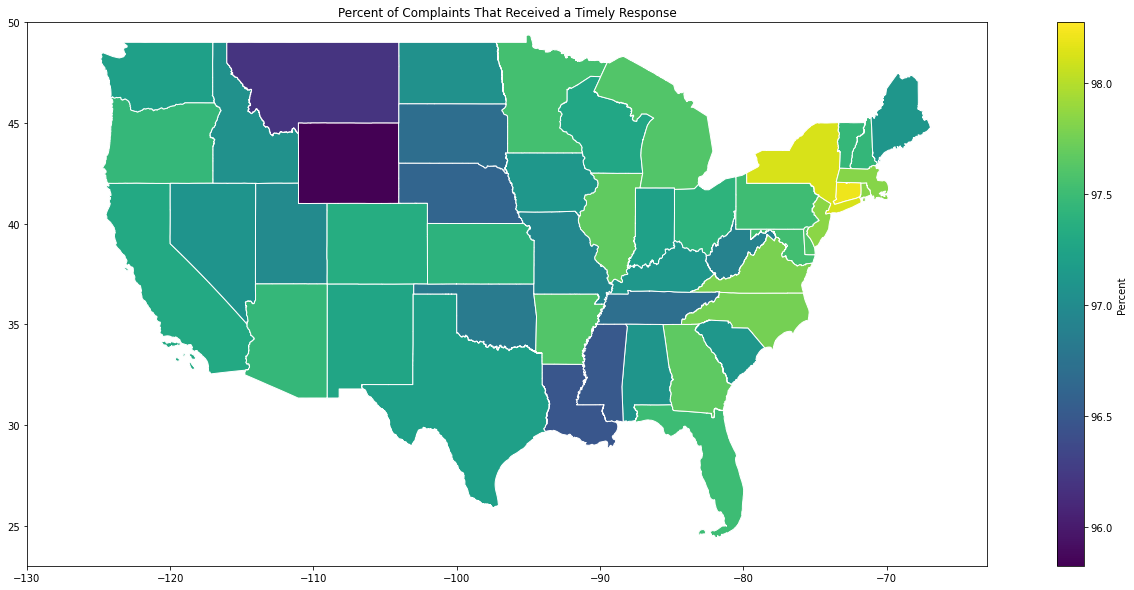

In [ ]:
choropleth('percentTimely', 'Percent of Complaints That Received a Timely Response', 'Percent')

Creates a scatterplot showing the correlation between the percent of complaints that received a timely response and were disputed

In [ ]:
def plot(xAxis,yAxis):
  plot = stateMap.plot.scatter(x = xAxis, y = yAxis, c = 'DarkBlue')
  m, b = np.polyfit(stateMap[xAxis], stateMap[yAxis], 1)
  plt.plot(stateMap[xAxis], m*stateMap[xAxis]+b)

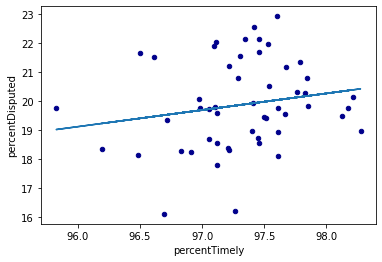

In [ ]:
plot('percentTimely','percentDisputed')

Shows more detailed results for the OLS linear regression used to find the line of best fit

In [ ]:
def regression(xAxis,yAxis):
  model = ols(xAxis + " ~ " + yAxis, data=stateMap).fit()
  return model.summary()

In [ ]:
modelSummary = regression("percentDisputed","percentTimely")
modelSummary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        percentDisputed   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.750
Date:                Fri, 30 Sep 2022   Prob (F-statistic):              0.192
Time:                        22:13:02   Log-Likelihood:                -94.686
No. Observations:                  52   AIC:                             193.4
Df Residuals:                      50   BIC:                             197.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -35.8964     42.162     -0.851      0.399    -120.581      48.788
percentTimely     0.5732      0.433      1.323      0.192      -0.297       1.443
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.351
Skew:                           0.002   Prob(JB):                        0.839
Kurtosis:                       2.597   Cond. No.                     1.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#Analyzes Different Categories for Complaints

Finds the frequency of each product 

In [ ]:
productFrequency = frequencyToDataframe(data, 'product')
productFrequency.head()

,product
Mortgage,186475
Debt collection,101052
Credit reporting,91854
Credit card,66468
Bank account or service,62563


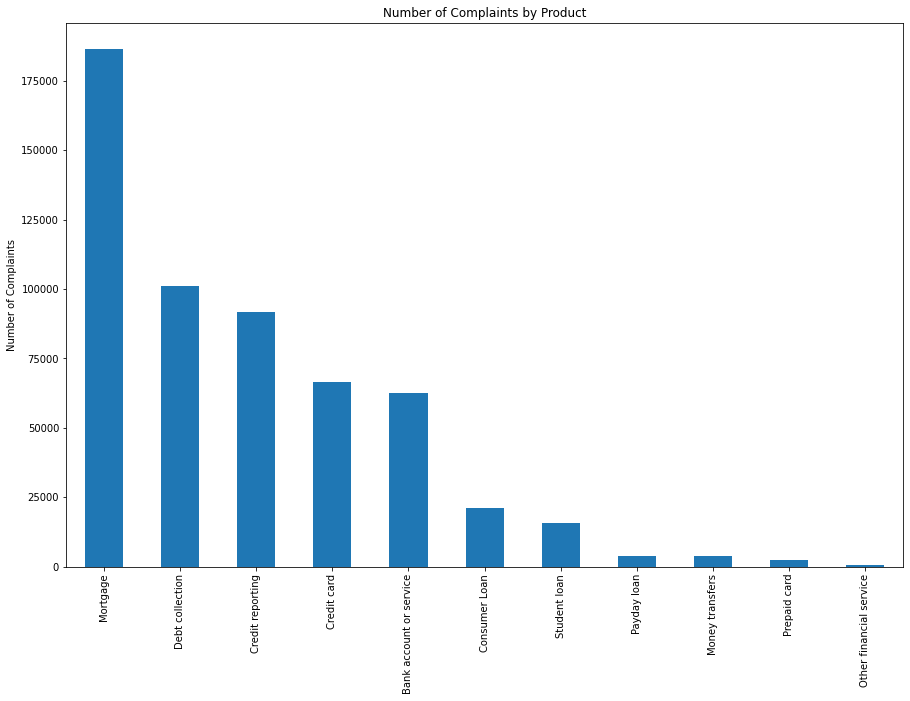

In [ ]:
productFrequency['product'].plot(kind="bar", figsize=(15, 10), title='Number of Complaints by Product', ylabel = 'Number of Complaints')

Finding how timely response and dispute rates are related to product

In [ ]:
timelyResponse = []
untimelyResponse = []
for i in range(len(productFrequency)):
  timelyResponse.append(len(data[(data['product']==productFrequency.index[i]) & (data['timely_response']=='Yes')]))
  untimelyResponse.append(len(data[(data['product']==productFrequency.index[i]) & (data['timely_response']=='No')]))
productFrequency['timelyResponse'] = timelyResponse
productFrequency['untimelyResponse'] = untimelyResponse

In [ ]:
disputed = []
notDisputed = []
for i in range(len(productFrequency)):
  disputed.append(len(data[(data['product']==productFrequency.index[i]) & (data['consumer_disputed?']=='Yes')]))
  notDisputed.append(len(data[(data['product']==productFrequency.index[i]) & (data['consumer_disputed?']=='No')]))
productFrequency['disputed'] = disputed
productFrequency['notDisputed'] = notDisputed

In [ ]:
productFrequency['percentTimely'] = productFrequency['timelyResponse'] / (productFrequency['timelyResponse'] + productFrequency['untimelyResponse']) * 100
productFrequency['percentDisputed'] = productFrequency['disputed'] / (productFrequency['disputed'] + productFrequency['notDisputed']) * 100

In [ ]:
productFrequency.head()

,product,timelyResponse,untimelyResponse,disputed,notDisputed,percentTimely,percentDisputed
Mortgage,186475,182245,4230,43276,143199,97.731599,23.207400
Debt collection,101052,93934,7118,18291,82761,92.956102,18.100582
Credit reporting,91854,91707,147,15072,76782,99.839963,16.408649
Credit card,66468,65871,597,13814,52654,99.101823,20.782933
Bank account or service,62563,61858,705,12308,50255,98.873136,19.672970


Plots timely response and dispute rates per product

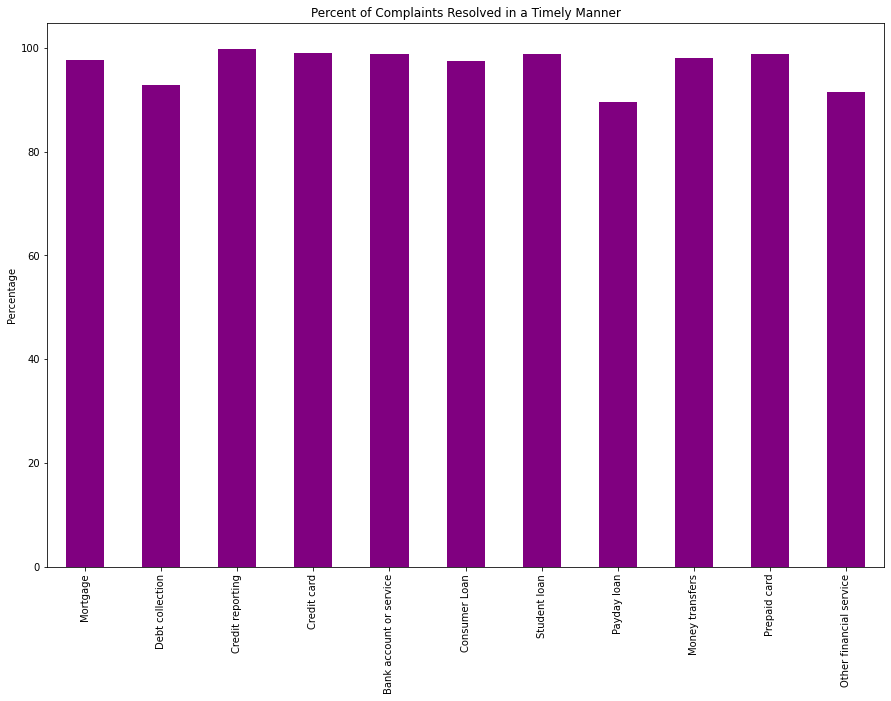

In [ ]:
productFrequency['percentTimely'].plot(kind="bar", figsize=(15, 10), title='Percent of Complaints Resolved in a Timely Manner', ylabel = 'Percentage', color = 'Purple')

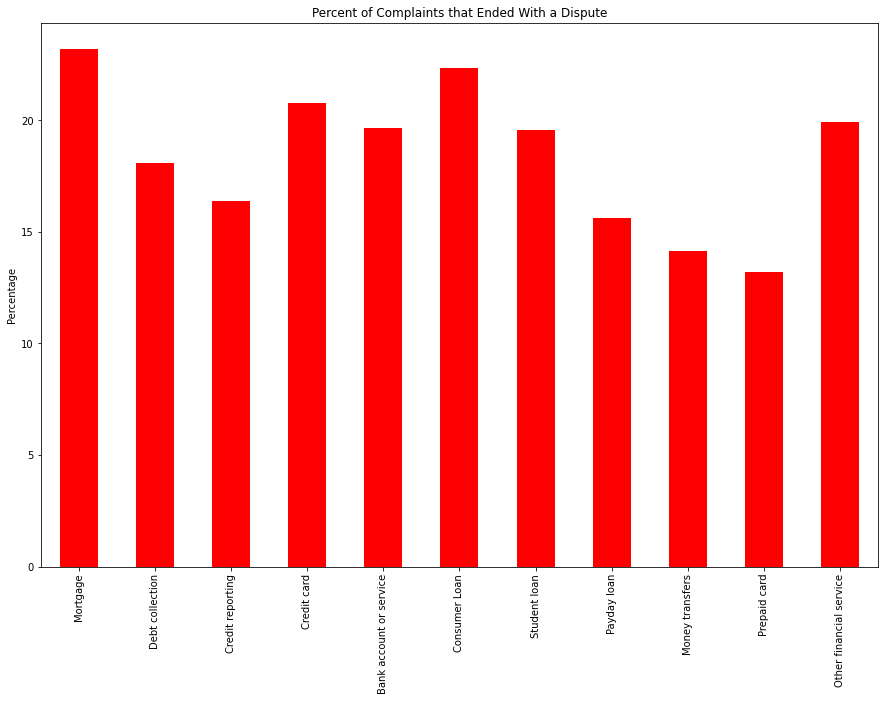

In [ ]:
productFrequency['percentDisputed'].plot(kind="bar", figsize=(15, 10), title='Percent of Complaints that Ended With a Dispute', ylabel = 'Percentage', color = 'Red')